In [92]:
# df.to_pickle('dataset_lcforest_LOF10_bin30_th3_1km_noprior_ta.pkl')

In [2]:
from scripts.parallel_blocks import *
import pandas as pd

df = pd.read_pickle('dataset_lcforest_mahal22_bin15_th3_fancy1km_noprior_ta.pkl')

df.pg.mean()

6.0306700875070405

### This can be used to adjust dataframes with a new outlier method or regression method.

In [12]:
from scripts.parallel_blocks import *
import pandas as pd

df_ = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')

# Create a column to fill later
df_['outlier'] = np.nan

# Grouping keys
group_keys = ['camera','date','lat','lon']
i=0
# Iterate over each group
for keys, test_plot in df_.groupby(group_keys):
    i+=1
    test_plot = test_plot.copy()

    try:
        coefs, _, test = df_odr(test_plot, outlier_removal=0.22, w=[1, 0.25])

        # Ensure index alignment for merging
        test_plot['outlier'] = test['Outlier'].values

        # Set the values back in the original df using index
        df_.loc[test_plot.index, 'outlier'] = test_plot['outlier']

        indices_to_insert = [i for i in range(1,7) if i not in test['beam'].unique()]

        for index in indices_to_insert:
            coefs = np.insert(coefs, index, None)

        if np.all(np.isnan([coefs[1],coefs[3],coefs[5]])):
            y_strong = np.nan
        else:
            y_strong = np.nanmean([coefs[1],coefs[3],coefs[5]])
            y_strong_max = np.nanmax([coefs[1],coefs[3],coefs[5]])
            
        if np.all(np.isnan([coefs[2],coefs[4],coefs[6]])):
            y_weak = np.nan
        else:
            y_weak = np.nanmean([coefs[2],coefs[4],coefs[6]])
            y_weak_max = np.nanmax([coefs[2],coefs[4],coefs[6]])
            
        if np.any(np.isnan([y_strong, y_weak])):
            pv_ratio_mean = np.nan
            pv_ratio_max = np.nan
        else:
            pv_ratio_mean = y_strong/y_weak
            pv_ratio_max = y_strong_max/y_weak_max
        
        y_intercept_dict = {1: coefs[1], 2: coefs[2], 3: coefs[3], 4: coefs[4], 5: coefs[5], 6: coefs[6]}
        x_intercept_dict = {1: -coefs[1]/coefs[0], 2: -coefs[2]/coefs[0], 3: -coefs[3]/coefs[0], 4: -coefs[4]/coefs[0],
                           5: -coefs[5]/coefs[0], 6: -coefs[6]/coefs[0]}

        df_.loc[test_plot.index,'pvpg'] = -coefs[0]
        df_.loc[test_plot.index,'pv'] = test_plot['beam'].map(y_intercept_dict)
        df_.loc[test_plot.index,'pg'] = test_plot['beam'].map(x_intercept_dict)
        df_.loc[test_plot.index,'pv_ratio_max'] = pv_ratio_max
        df_.loc[test_plot.index,'pv_ratio_mean'] = pv_ratio_mean

    except Exception as e:
        print(f"Skipping group {keys} due to error: {e}")
        continue

    # print(params)
    # print(test_plot)
    # print(test)

# All 18 Sites!

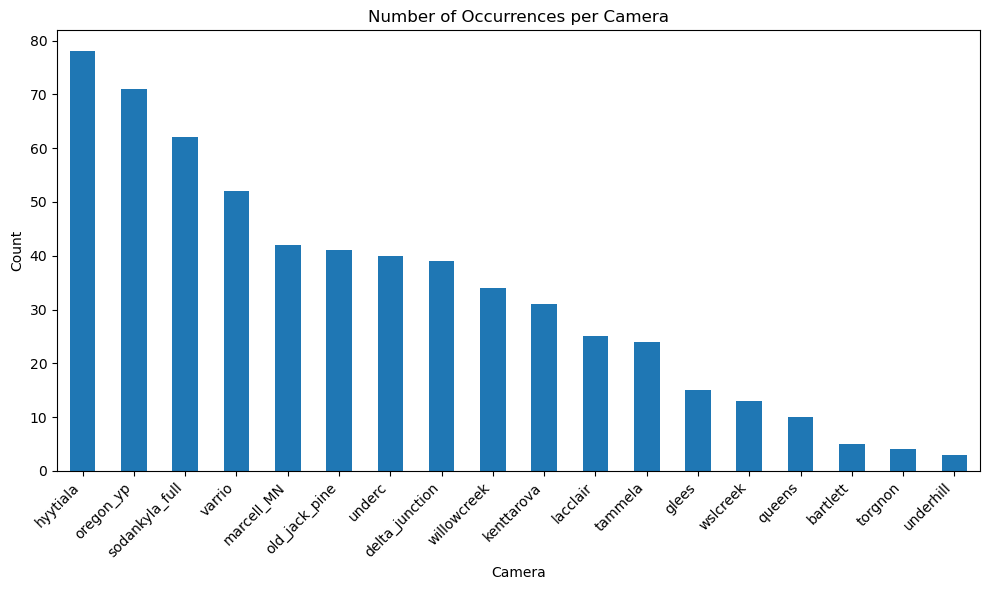

In [18]:
# Assuming your dataframe is called `data`
counts = data['camera'].value_counts()

plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.xlabel('Camera')
plt.ylabel('Count')
plt.title('Number of Occurrences per Camera')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

1819


/tmp/ipykernel_2291949/1487483955.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


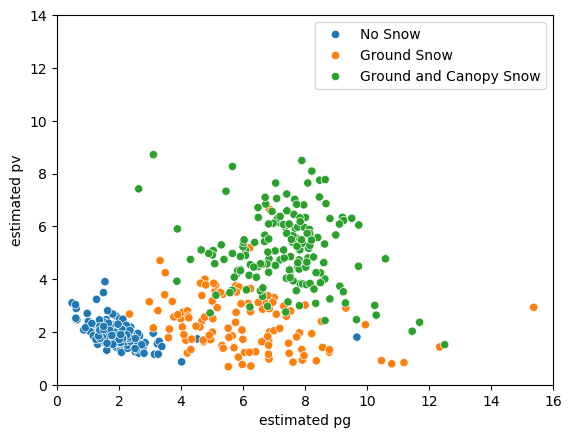

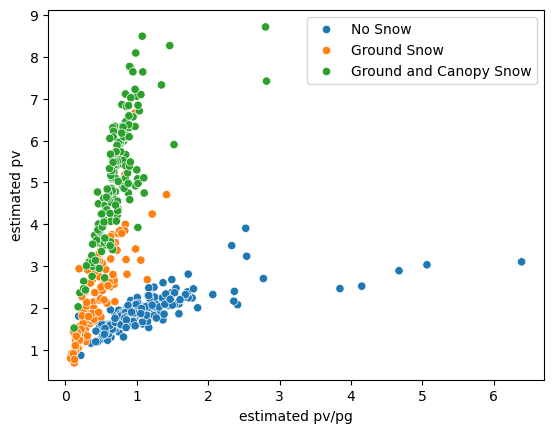

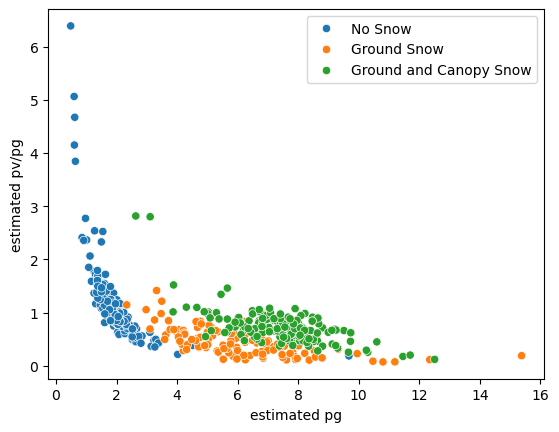

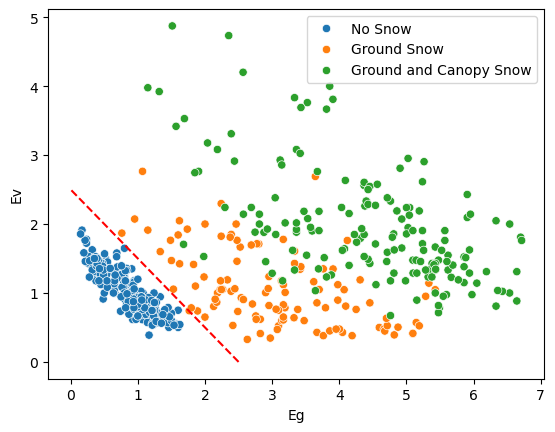

In [64]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')
# df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy750m_noprior_ta.pkl')

# df = df_.copy()
# print(df)
# mask = df['beam'] == 3
# df.loc[mask, ['pv','pg','Ev','Eg']] /= 0.85

# First create masked columns
df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
print(len(df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))]))
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.1)#&(df_grouped['Ev_strong']/df_grouped['Ev_weak'] >= 1.1)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 27)]
data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.round(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
# plt.plot([4.2,0],[0,9],'r--') #LOF10_bin20_DW 570 points
# plt.plot([5,0],[0,7.5],'r--') #LOF10_bin30_DW 596 points
                                #LOF10_bin20 578 points
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated pv')
# plt.xlim(0,3)
# plt.ylim(0,12)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
# plt.xlim(0,20)
# plt.ylim(0,20)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='Eg_strong', y='Ev_strong', hue='Conditions')#, size='data_quantity')
plt.xlabel('Eg')
plt.ylabel('Ev')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin20 570 points
plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin30 596 points
plt.legend(loc='best')
plt.show()

#### Logistic Regression

In [65]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your dataframe is called df
# features = ['pvpg', 'pv', 'pg', 'snr', 'pv_ratio_mean', 'pv_ratio_max']
features = ['Ev_strong','Eg_strong']#,'pv', 'pg', 'pvpg']
target = 'JointSnowBinary'

data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features]
y = data[target]

# Optional: standardize the features (helps logistic regression perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on all data
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, penalty=None)
model.fit(X_scaled, y)

# Predict on the same data (since you said to use all data)
y_pred = model.predict(X_scaled)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Get boolean mask of incorrect predictions
incorrect_mask = y != y_pred

# Optionally convert y to numpy array if needed
# y = y.to_numpy()

# Get the misclassified rows from the original dataframe
misclassified = data[incorrect_mask]

# Add true and predicted labels to the misclassified DataFrame for inspection
misclassified = misclassified.copy()
misclassified['TrueLabel'] = y[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show the result
misclassified.sort_values(['JointSnow','camera','date'])

Confusion Matrix:
[[223   0]
 [  0 279]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       1.00      1.00      1.00       279

    accuracy                           1.00       502
   macro avg       1.00      1.00      1.00       502
weighted avg       1.00      1.00      1.00       502



/tmp/ipykernel_2291949/2964566048.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,Eg_weak,...,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,JointSnowBinary,TrueLabel,PredictedLabel


#### Linear function of pv and pg

In [16]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your dataframe is called df
# features = ['pvpg', 'pv', 'pg', 'snr', 'pv_ratio_mean', 'pv_ratio_max']
features = ['pv', 'pg', 'pvpg']#,'Ev_strong','Eg_strong',]
target = 'JointSnowBinary'

data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features]
y = data[target]

# Optional: standardize the features (helps logistic regression perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on all data
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, penalty=None)
model.fit(X_scaled, y)

# Predict on the same data (since you said to use all data)
y_pred = model.predict(X_scaled)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Get boolean mask of incorrect predictions
incorrect_mask = y != y_pred

# Optionally convert y to numpy array if needed
# y = y.to_numpy()

# Get the misclassified rows from the original dataframe
misclassified = data[incorrect_mask]

# Add true and predicted labels to the misclassified DataFrame for inspection
misclassified = misclassified.copy()
misclassified['TrueLabel'] = y[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show the result
misclassified.sort_values(['JointSnow','camera','date'])

Confusion Matrix:
[[282   4]
 [ 12 257]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       286
           1       0.98      0.96      0.97       269

    accuracy                           0.97       555
   macro avg       0.97      0.97      0.97       555
weighted avg       0.97      0.97      0.97       555



/tmp/ipykernel_362537/3029202463.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,data_quantity,...,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,JointSnowBinary,TrueLabel,PredictedLabel
2676,underc,07/05/2019,46.227143,-89.579656,0.083312,1.323971,15.891767,4.313725,0.904977,23.000000,...,0.0,0.0,0.0,NaN,NaN,0.0,No Snow,0,0,1
2854,underhill,07/11/2021,44.527252,-72.846087,0.555310,2.149833,3.871414,0.816176,1.552778,23.620690,...,0.0,5.0,0.0,1.415580,1.415580,0.0,No Snow,0,0,1
3117,willowcreek,05/09/2020,45.817261,-90.051450,0.174904,1.800639,10.294989,1.578947,1.571429,31.129032,...,0.0,7.0,0.0,1.975942,1.975942,0.0,No Snow,0,0,1
3241,willowcreek,15/06/2019,45.839784,-90.060042,0.137783,1.795168,13.028996,2.441176,1.512605,32.000000,...,0.0,3.0,0.0,NaN,NaN,0.0,No Snow,0,0,1
95,bartlett,31/01/2021,44.075861,-71.243271,3.376928,3.759916,1.113413,0.533333,1.866667,22.714286,...,0.0,6.0,0.0,1.182391,1.182391,1.0,Ground Snow,1,1,0
347,delta_junction,30/04/2022,63.869839,-145.788221,0.436778,1.901914,4.354419,3.193277,0.470588,23.391304,...,0.0,19.0,0.0,1.642809,1.642809,1.0,Ground Snow,1,1,0
348,delta_junction,30/04/2022,63.874343,-145.789414,0.420834,1.805265,4.289736,2.043344,0.825593,25.980392,...,0.0,19.0,0.0,1.975319,1.975319,1.0,Ground Snow,1,1,0
1130,marcell_MN,20/03/2022,47.538684,-93.439705,0.325965,1.480065,4.540564,1.872368,0.830144,22.409091,...,0.0,16.0,0.0,1.832224,1.832224,1.0,Ground Snow,1,1,0
1263,marcell_MN,30/10/2020,47.489134,-93.474873,0.376562,1.505988,3.999315,1.564474,0.973684,24.459459,...,0.0,9.0,0.0,1.824053,1.824053,1.0,Ground Snow,1,1,0
3242,willowcreek,28/02/2024,45.772216,-90.076248,0.113407,0.854146,7.531654,3.413095,0.418831,28.529412,...,0.0,17.0,0.0,1.702053,1.702053,1.0,Ground Snow,1,1,0


# Plotting ATL08 from the Dataframe

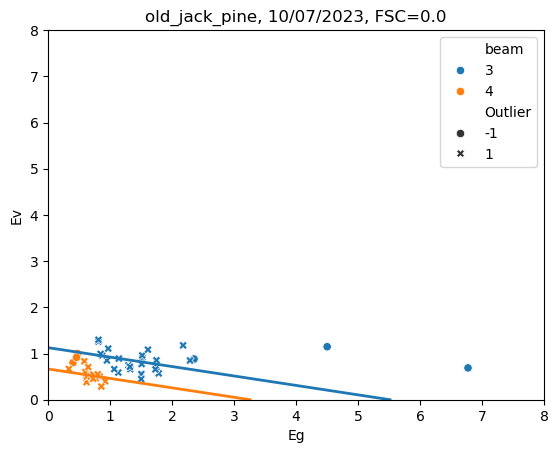

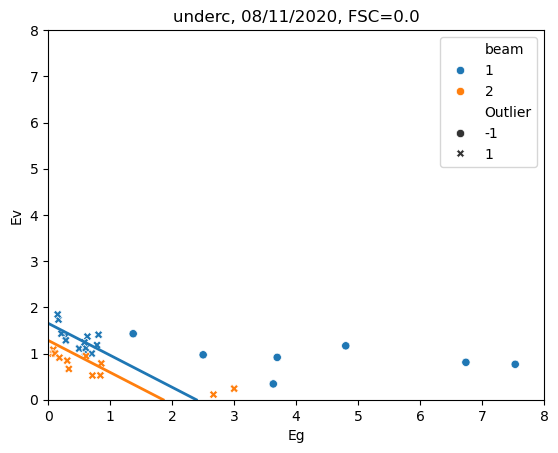

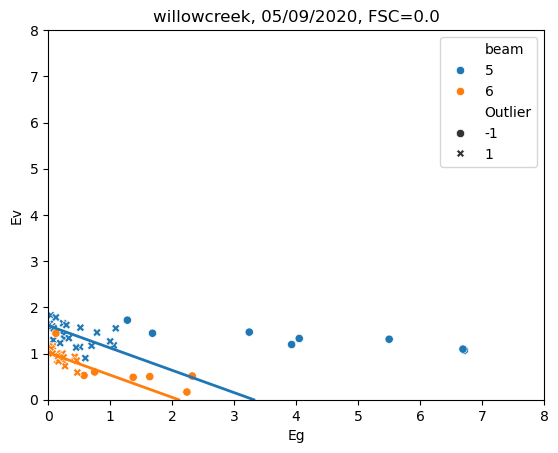

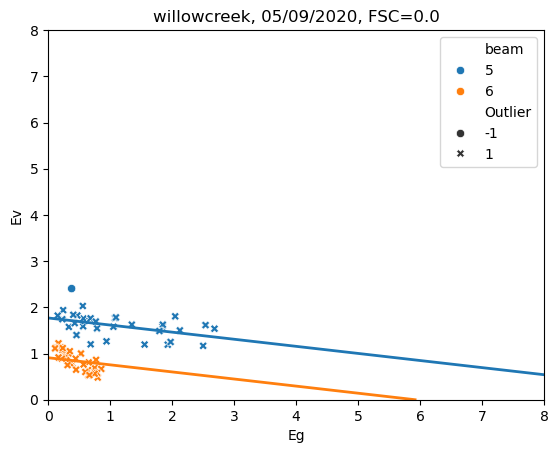

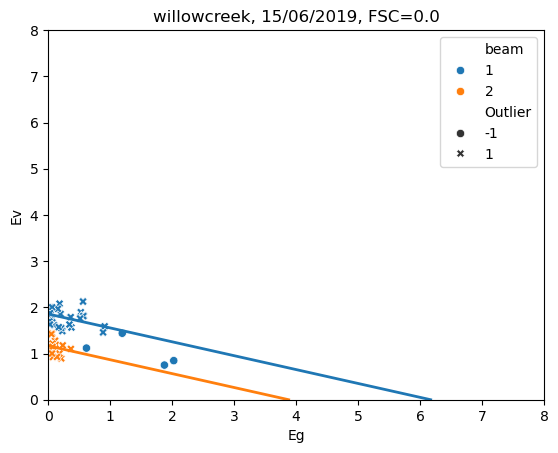

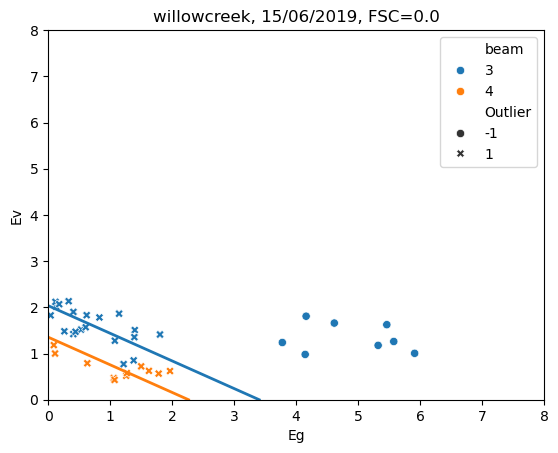

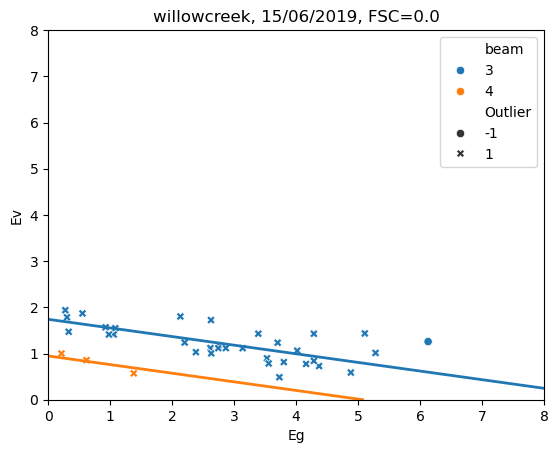

In [11]:
from scripts.parallel_blocks import *
    
# misclassified.columns
for idx, row in misclassified.iterrows():
    if row['FSC'] <= 0.05:
        plt.figure()
        plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
        
        test_plot = df[(df['camera'] == row['camera']) &
                       (df['date'] == row['date']) &
                       (df['lon'] == row['lon']) &
                       (df['lat'] == row['lat'])].copy()

        params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

        # print(test)

        # Get sorted unique beams (hue order used by seaborn)
        beam_order = sorted(test['beam'].unique())

        # Create mapping from beam label to tab10 color
        tab10 = cm.get_cmap('tab10')
        color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

        # Plot with fixed hue order and palette
        sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
                        hue_order=beam_order, palette=color_map)

        # Plot ODR lines in matching colors
        for b, beam in zip(params[1:], beam_order):
            plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

        plt.xlim(0, 8)
        plt.ylim(0, 8)
        plt.legend()
        plt.show()

        # break

# Fractional

/tmp/ipykernel_1041621/1692945481.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)


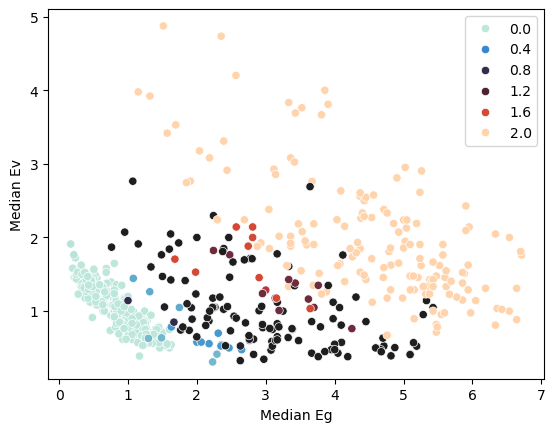

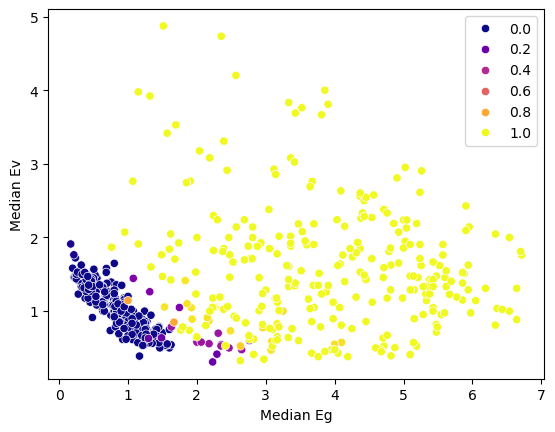

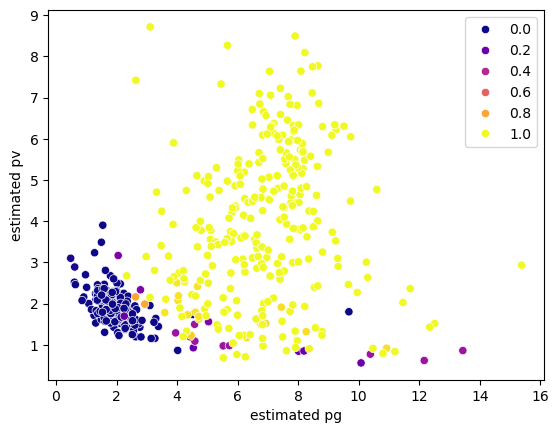

522


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,Eg_weak,...,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,JointSnowBinary
460,kenttarova,03/08/2020,67.991788,24.333955,1.354620,2.238703,1.652642,1.000000,0.894737,0.500000,...,1.156412,0.0,0.0,0.0,12.0,0.0,1.637328,1.637328,0.0,0.0
1206,sodankyla_full,09/07/2021,67.348319,26.655055,0.865768,1.587670,1.833828,0.941176,0.785714,0.666667,...,2.119592,0.0,0.0,0.0,17.0,0.0,1.398231,1.398231,0.0,0.0
1204,sodankyla_full,09/07/2021,67.339310,26.652633,0.544962,1.371489,2.516671,0.857143,0.875000,0.285714,...,2.373009,0.0,0.0,0.0,17.0,0.0,1.315602,1.315602,0.0,0.0
1203,sodankyla_full,09/07/2021,67.330301,26.725655,0.846258,1.582385,1.869860,0.915033,0.840336,0.450000,...,4.452532,0.0,0.0,0.0,17.0,0.0,1.258761,1.258761,0.0,0.0
1202,sodankyla_full,09/07/2021,67.330301,26.650241,2.538344,3.235351,1.274591,1.000000,0.666667,0.612500,...,2.308852,0.0,0.0,0.0,17.0,0.0,1.427340,1.427340,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,marcell_MN,26/01/2023,47.518414,-93.418533,0.369474,3.082850,8.343882,5.428571,1.000000,1.449580,...,374.949191,1.0,1.0,0.0,21.0,0.0,3.084892,3.084892,2.0,1.0
683,marcell_MN,26/01/2023,47.518414,-93.461380,0.473278,2.944855,6.222254,4.761905,0.672269,1.400000,...,226.489750,1.0,1.0,0.0,21.0,0.0,2.613666,2.613666,2.0,1.0
682,marcell_MN,26/01/2023,47.518414,-93.504274,0.946558,6.564869,6.935517,5.428571,1.333333,1.823529,...,506.725519,1.0,1.0,0.0,21.0,0.0,3.413376,3.413376,2.0,1.0
689,marcell_MN,26/01/2023,47.536432,-93.458850,0.633035,4.069978,6.429305,3.193277,2.016807,0.916667,...,230.910873,1.0,1.0,0.0,21.0,0.0,2.762692,2.762692,2.0,1.0


In [1]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] >= 0.00)&(df_grouped['FSC'] <= 1.00))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.2)#&(df_grouped['Ev_strong']/df_grouped['Ev_weak'] >= 1.1)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 27)]
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnow', palette='icefire')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnowBinary', palette='plasma')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='pg', y='pv', hue='JointSnowBinary', palette='plasma')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(frac_data))
frac_data.sort_values('FSC')

/tmp/ipykernel_2291949/4004111171.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)


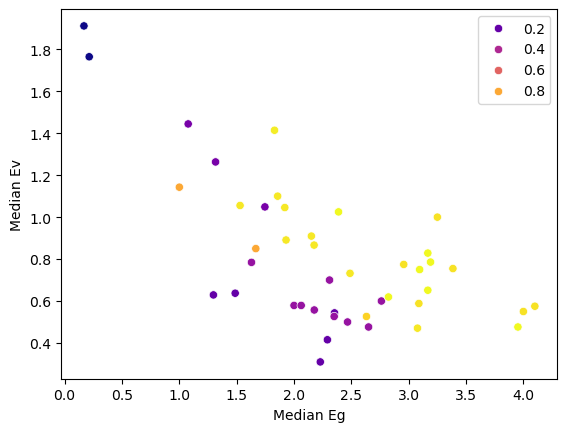

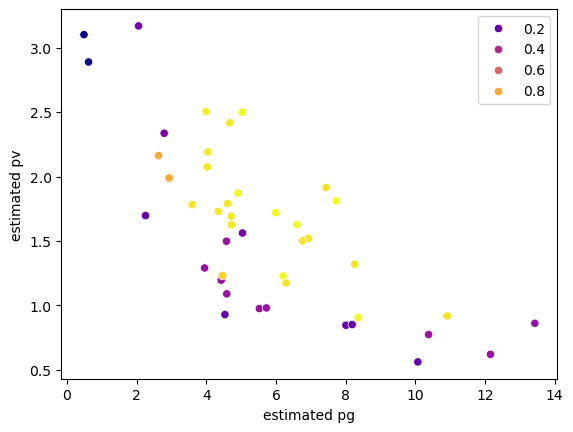

44


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,Eg_weak,...,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,JointSnowBinary
1914,wslcreek,23/10/2023,39.913923,-105.903778,6.389692,3.100944,0.485304,0.168067,1.911765,0.111111,...,0.373098,0.02,0.0,0.000000,14.0,0.0,1.622604,1.622604,0.02,0.02
1911,wslcreek,23/10/2023,39.895905,-105.905789,4.672310,2.888945,0.618312,0.213904,1.764706,0.118056,...,0.357741,0.02,0.0,0.000000,14.0,0.0,1.572030,1.572030,0.02,0.02
71,delta_junction,02/05/2021,63.867586,-145.769149,0.105647,0.846117,8.008945,2.352941,0.543344,0.944444,...,0.866235,0.20,0.0,0.000000,16.0,0.0,1.613743,1.613743,0.20,0.20
72,delta_junction,02/05/2021,63.876595,-145.771246,0.204834,0.928807,4.534446,2.291022,0.415225,0.928571,...,0.841385,0.20,0.0,0.000000,16.0,0.0,1.463351,1.463351,0.20,0.20
73,delta_junction,02/05/2021,63.885605,-145.773318,0.055724,0.561393,10.074529,2.229102,0.309598,0.883117,...,0.859275,0.20,0.0,0.000000,16.0,0.0,0.812037,0.812037,0.20,0.20
158,delta_junction,26/04/2024,63.876595,-145.756934,0.752970,1.696849,2.253542,1.486842,0.637218,0.436508,...,0.303764,0.20,0.0,0.000000,32.0,0.0,1.380338,1.380338,0.20,0.20
152,delta_junction,26/04/2024,63.849568,-145.750302,0.103964,0.851402,8.189417,1.297059,0.629085,0.200000,...,0.270098,0.20,0.0,0.000000,32.0,0.0,1.026356,1.026356,0.20,0.20
81,delta_junction,03/05/2020,63.876595,-145.805841,1.543325,3.168583,2.053089,1.076923,1.444444,0.400000,...,0.252075,0.25,0.0,0.000000,8.0,0.0,1.895639,1.895639,0.25,0.25
86,delta_junction,03/05/2020,63.894614,-145.809919,0.310046,1.561783,5.037266,1.746032,1.048810,0.333333,...,0.292784,0.25,0.0,0.000000,8.0,0.0,1.467422,1.467422,0.25,0.25
83,delta_junction,03/05/2020,63.885605,-145.807932,0.837430,2.335950,2.789429,1.315789,1.263158,0.125000,...,0.273962,0.25,0.0,0.000000,8.0,0.0,1.775302,1.775302,0.25,0.25


In [75]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] > 0.00)&(df_grouped['FSC'] < 1.00))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.2)#&(df_grouped['Ev_strong']/df_grouped['Ev_weak'] >= 1.1)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 27)]
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnow', palette='plasma')#, size='data_quantity')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='pg', y='pv', hue='JointSnow', palette='plasma')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(frac_data))
frac_data.sort_values('FSC')

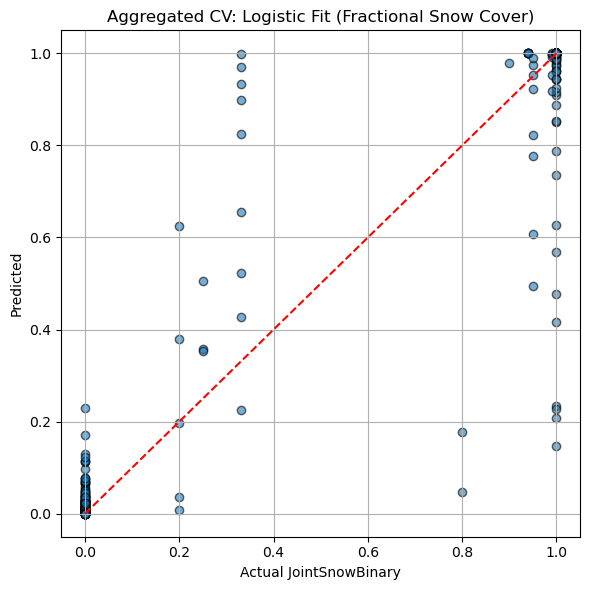

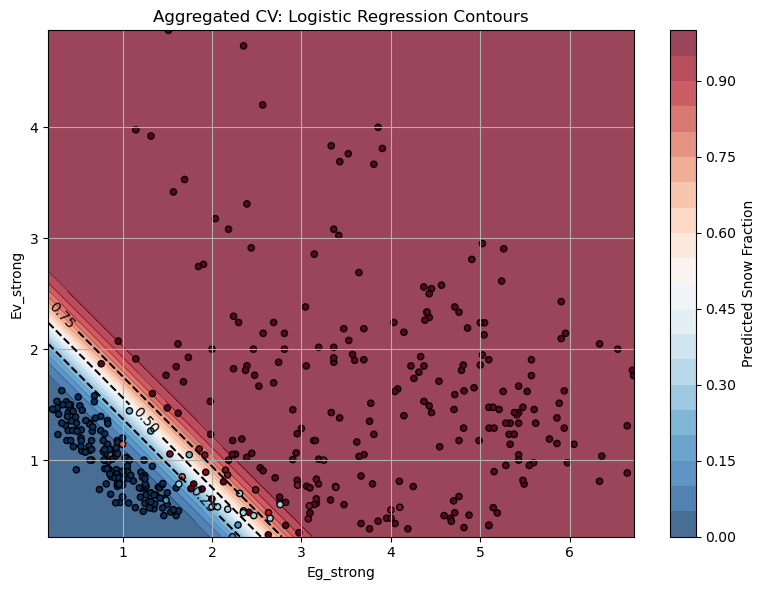

Cross-Validation RMSE (mean ± std): 0.1183 ± 0.0650
Cross-Validation Bias (mean ± std): -0.0024 ± 0.0375
Fractional RMSE (mean ± std): 0.2662 ± 0.0502
Fractional Bias (mean ± std): -0.0031 ± 0.1259

Classification Accuracy (4-bin): 84.96%

Confusion Matrix (Aggregated across folds):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)         133          20           0         0
[0.05,0.5)         2           6           7         2
[0.5,0.95)         1           1           2         7
[0.95,1]           0           7          16       215


In [78]:
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# Drop missing
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date"]).copy()

# Split by extremes vs midrange
extremes = df[(df["JointSnowBinary"] == 0) | (df["JointSnowBinary"] == 1)]
midrange = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)]

# Combine extremes and midrange
combined = pd.concat([extremes, midrange])

# Group cameras into test/train
cameras = combined['date'].unique()
np.random.seed(1)
np.random.shuffle(cameras)

# Compute approximate 20% camera-based test split
n_test = int(round(len(cameras) * 0.2))
test_cameras = cameras[:n_test]
# print(test_cameras)
train_cameras = cameras[n_test:]

train = combined[combined['date'].isin(train_cameras)].copy()
test = combined[combined['date'].isin(test_cameras)].copy()

# Define predictors and targets
X_train = train[["Eg_strong", "Ev_strong"]]
y_train = train["JointSnowBinary"]
groups = train["date"]  # grouping for cross-validation

X_test = test[["Eg_strong", "Ev_strong"]]
y_test = test["JointSnowBinary"]

# print(len(X_test))

# 4-fold Group CV
gkf = GroupKFold(n_splits=4)
cv_rmses = []
cv_rmses_fractional = []
cv_biases = []
cv_biases_fractional = []
cv_bin_accuracies = []

all_y_val = []
all_y_pred = []
all_Eg_val = []
all_Ev_val = []
all_yval_color = []
all_actual_bins = []
all_pred_bins = []

for i, (train_idx, val_idx) in enumerate(gkf.split(X_train, y_train, groups=groups), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # print(len(X_val))

    X_tr_sm = sm.add_constant(X_tr)
    X_val_sm = sm.add_constant(X_val)

    model = sm.GLM(y_tr, X_tr_sm, family=sm.families.Binomial(link=sm.families.links.Probit()))
    result = model.fit()
    y_pred = result.predict(X_val_sm)

    actual_bins = y_val.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)

    bin_accuracy = (actual_bins == pred_bins).mean()
    cv_bin_accuracies.append(bin_accuracy)

    all_actual_bins.extend(actual_bins)
    all_pred_bins.extend(pred_bins)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    cv_rmses.append(rmse)
    bias = np.mean(y_pred - y_val)
    cv_biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
        frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
        cv_rmses_fractional.append(frac_rmse)
        cv_biases_fractional.append(frac_bias)

    # Aggregate for analysis
    all_y_val.extend(y_val)
    all_y_pred.extend(y_pred)
    all_Eg_val.extend(X_val["Eg_strong"])
    all_Ev_val.extend(X_val["Ev_strong"])
    all_yval_color.extend(y_val)

# Fit final model on full training set
X_train_sm = sm.add_constant(X_train)
final_model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial(link=sm.families.links.Probit())).fit()

# Plot 1: Combined Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title("Aggregated CV: Logistic Fit (Fractional Snow Cover)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Contour using full training model
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_df = pd.DataFrame({
    "const": 1,
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel()
})
Z = final_model.predict(grid_df).values.reshape(Eg_grid.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')
plt.scatter(all_Eg_val, all_Ev_val, c=all_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Aggregated CV: Logistic Regression Contours")
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
print(f"Cross-Validation RMSE (mean ± std): {np.mean(cv_rmses):.4f} ± {np.std(cv_rmses):.4f}")
print(f"Cross-Validation Bias (mean ± std): {np.mean(cv_biases):.4f} ± {np.std(cv_biases):.4f}")
print(f"Fractional RMSE (mean ± std): {np.mean(cv_rmses_fractional):.4f} ± {np.std(cv_rmses_fractional):.4f}")
print(f"Fractional Bias (mean ± std): {np.mean(cv_biases_fractional):.4f} ± {np.std(cv_biases_fractional):.4f}")

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(all_actual_bins, all_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)

print(f"\nClassification Accuracy (4-bin): {np.mean(cv_bin_accuracies):.2%}")
print("\nConfusion Matrix (Aggregated across folds):")
print(conf_df)

### Plotting fractional data

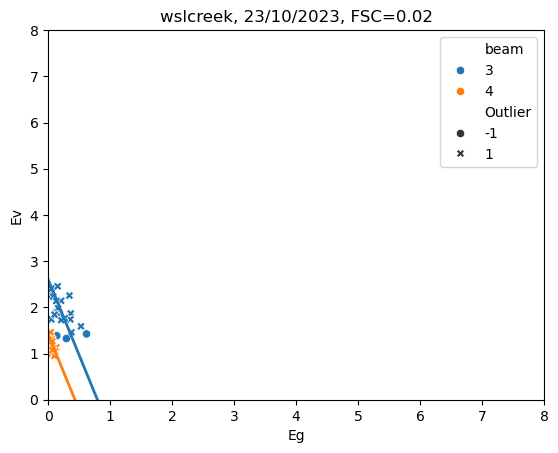

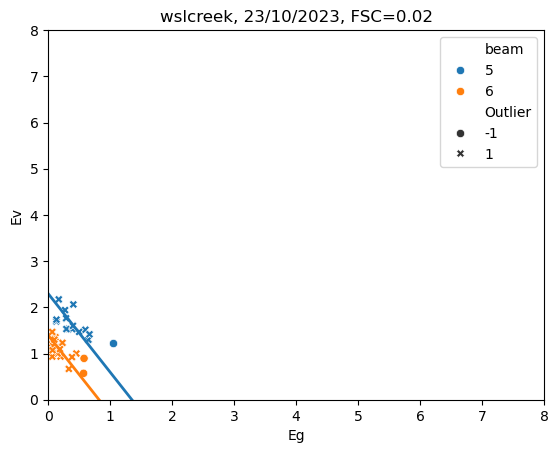

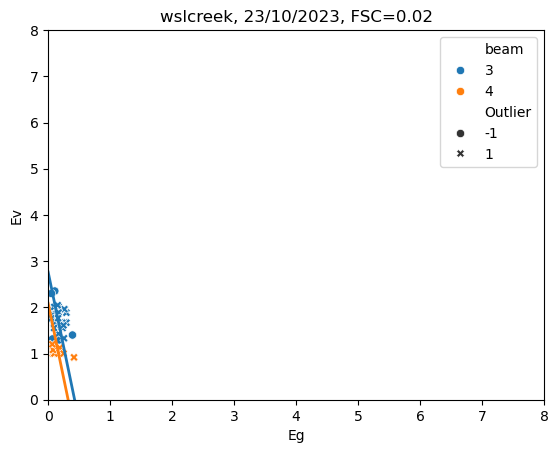

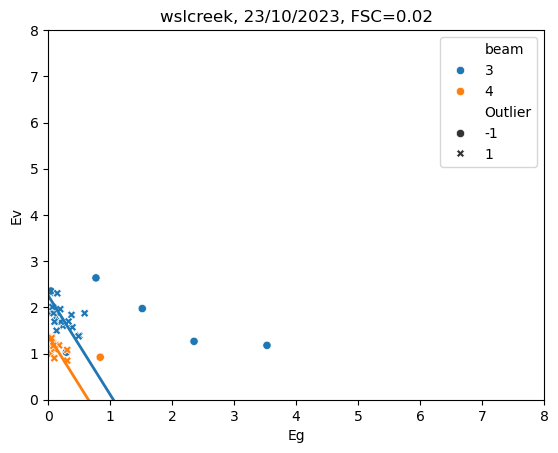

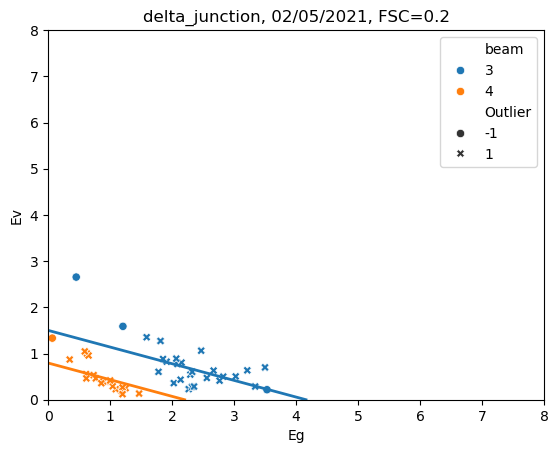

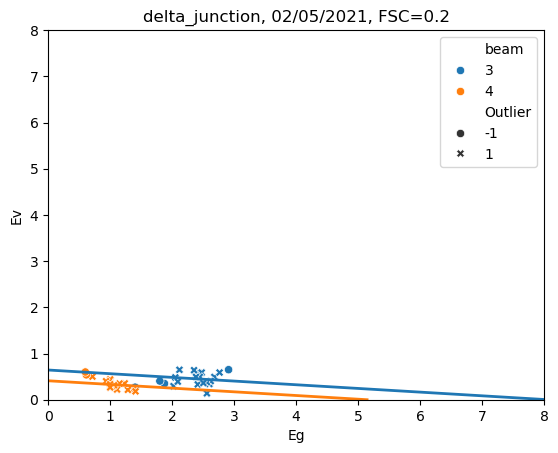

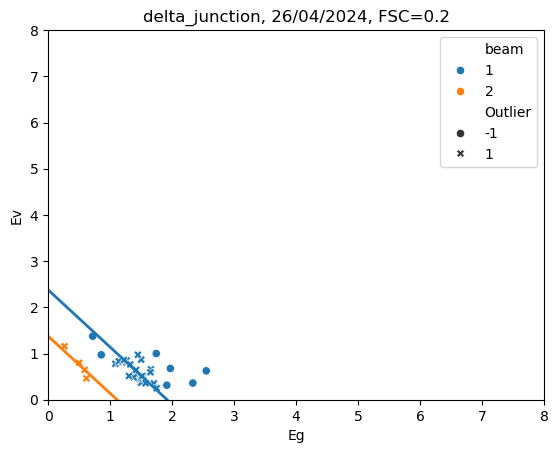

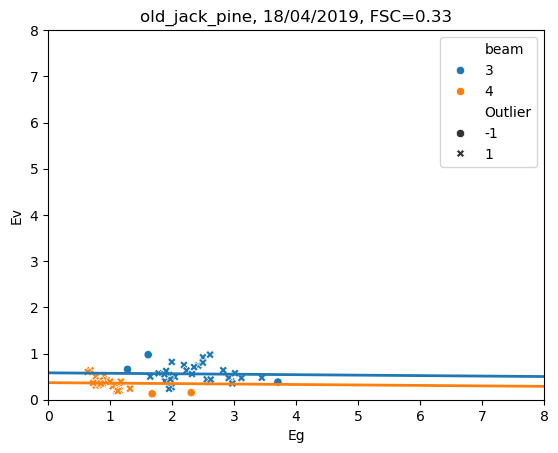

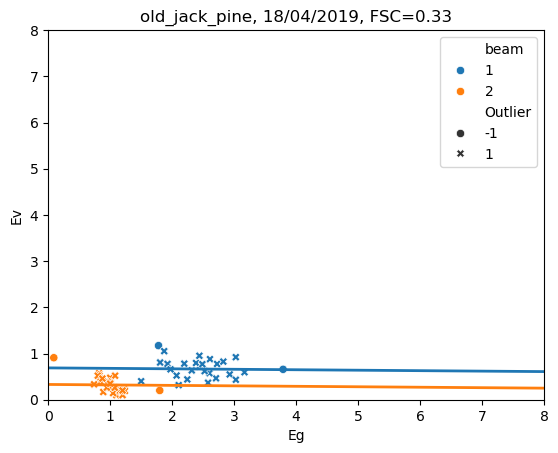

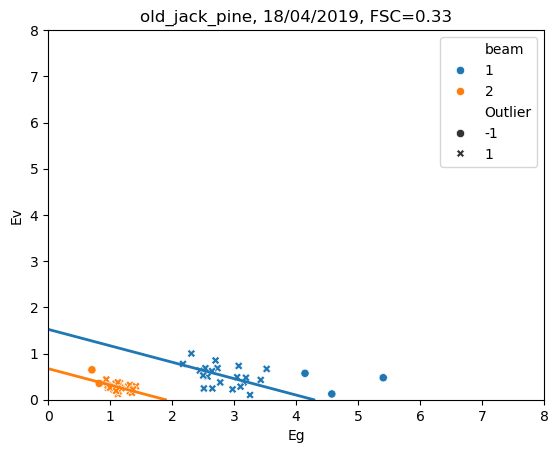

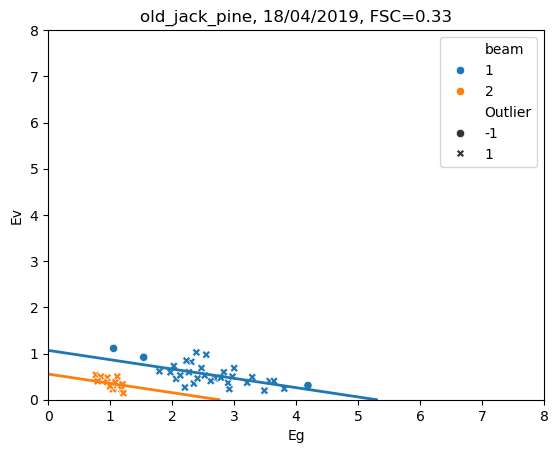

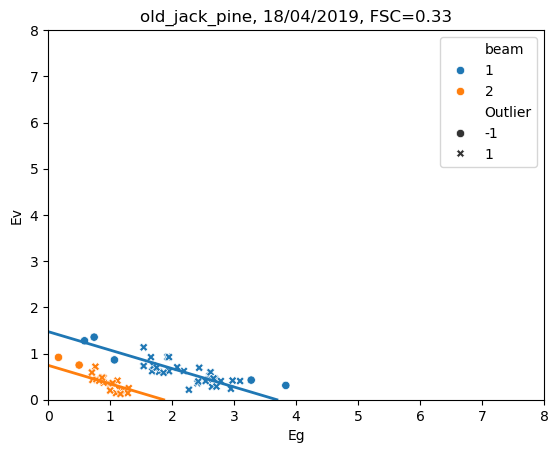

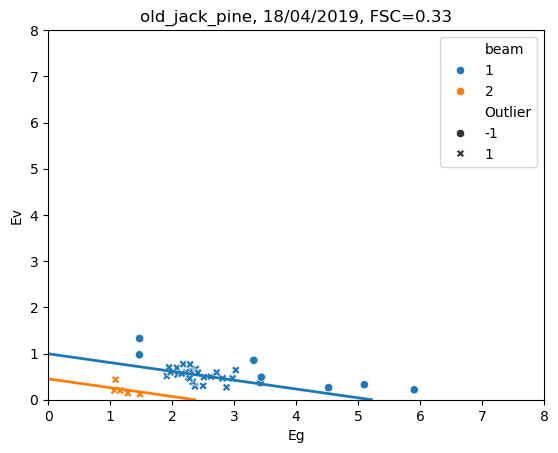

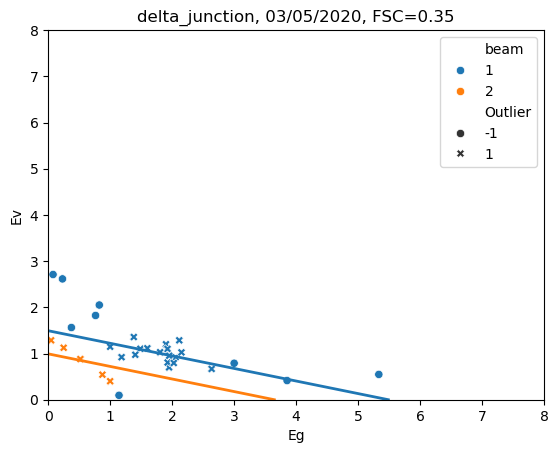

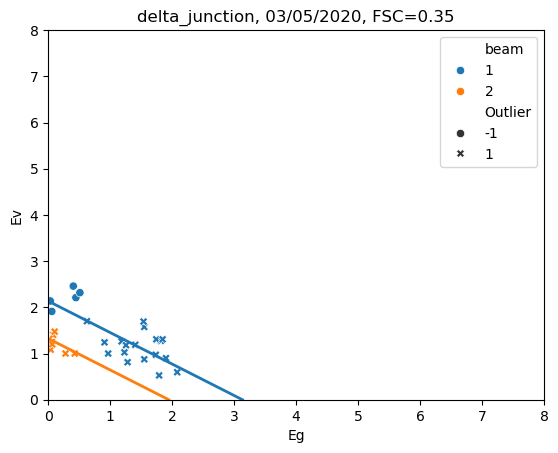

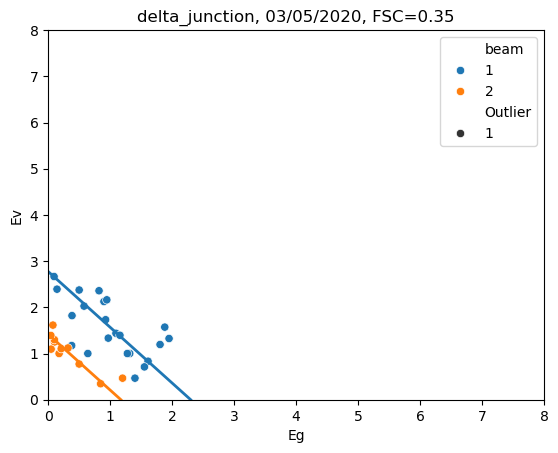

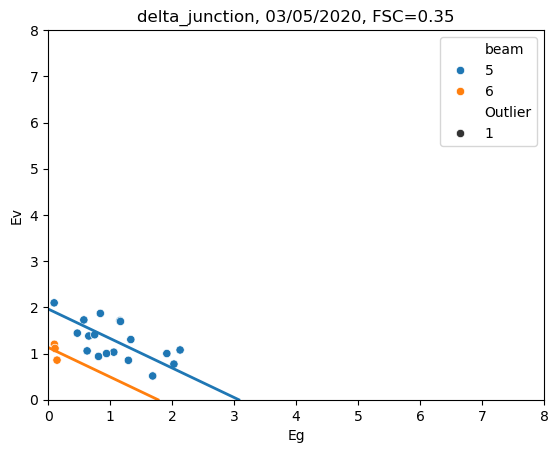

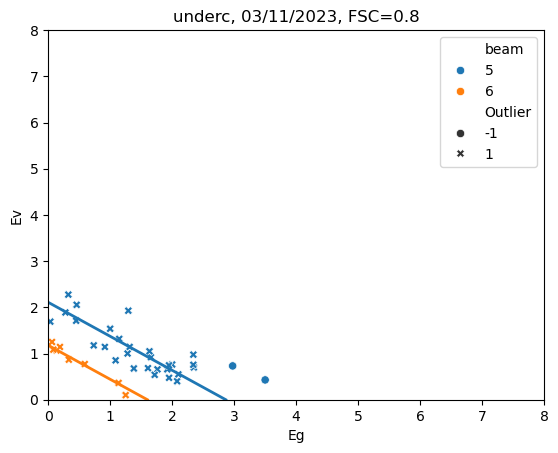

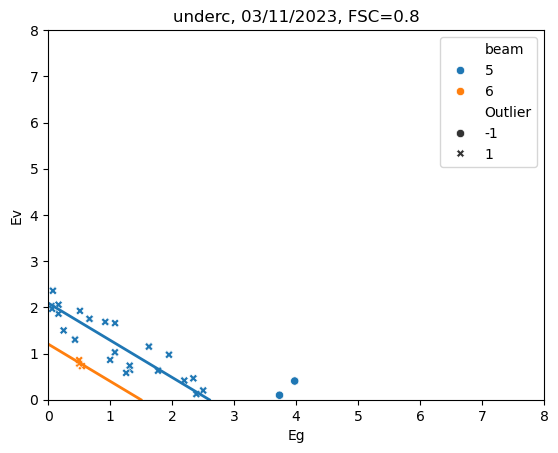

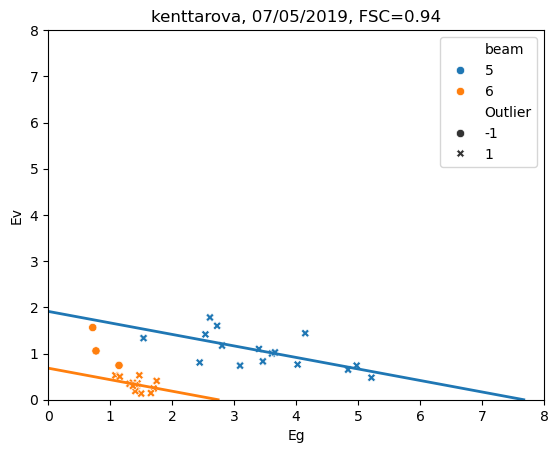

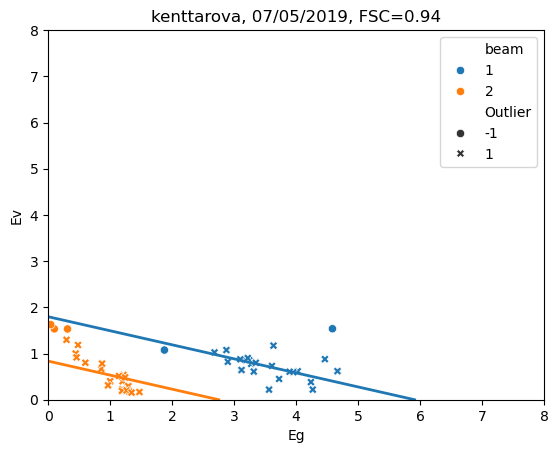

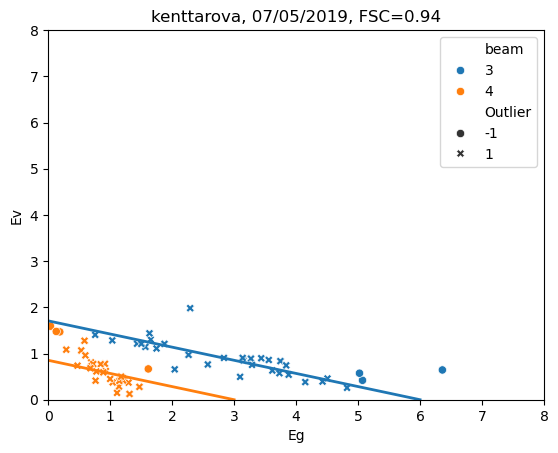

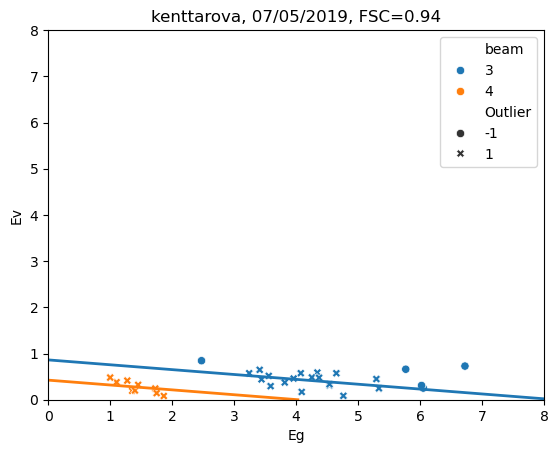

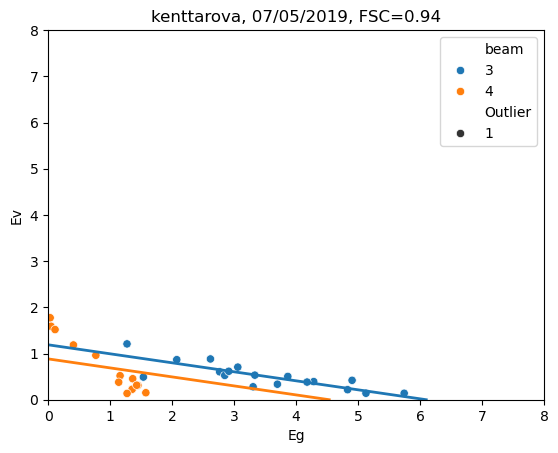

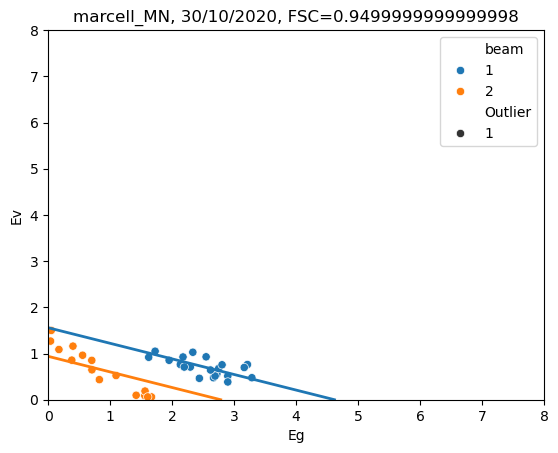

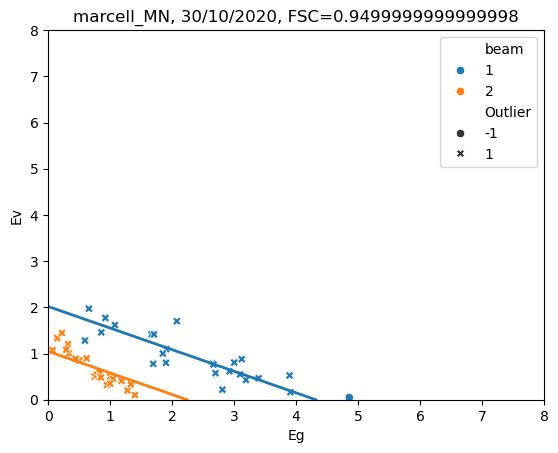

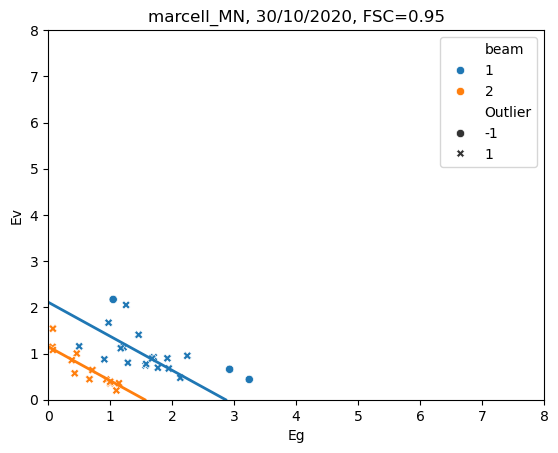

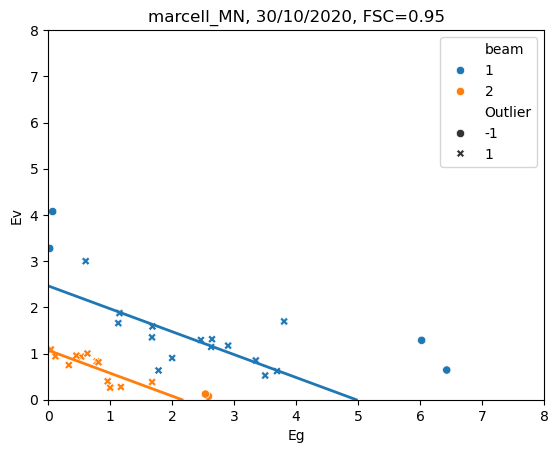

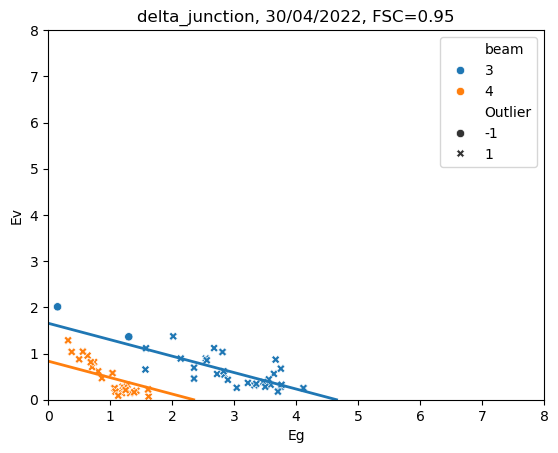

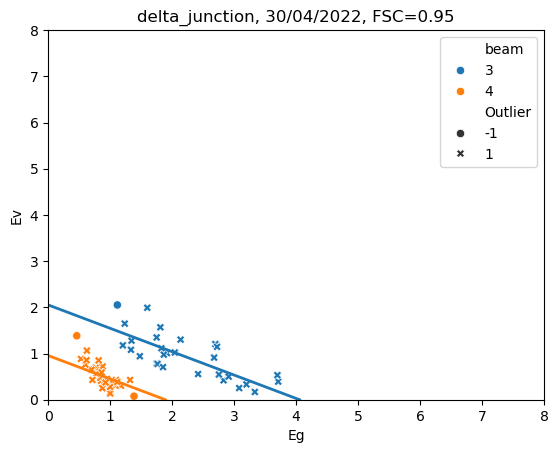

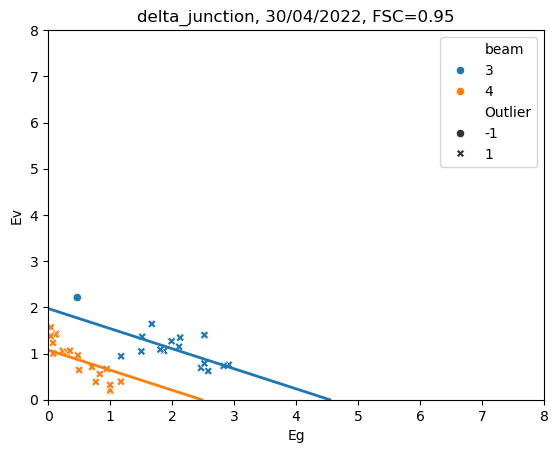

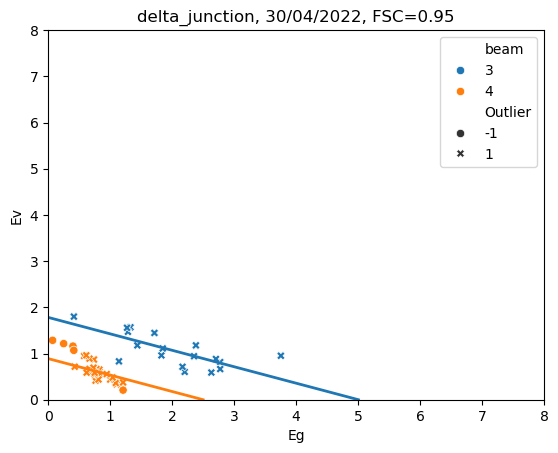

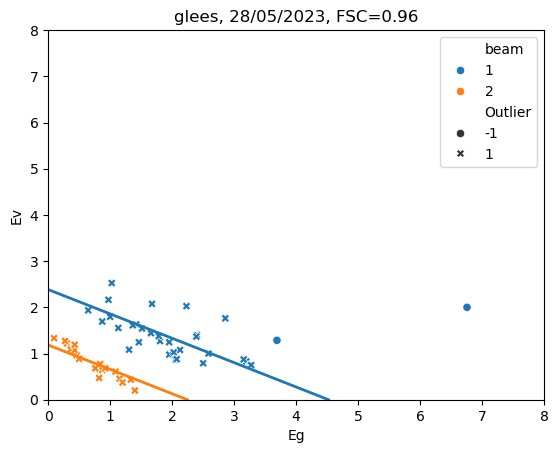

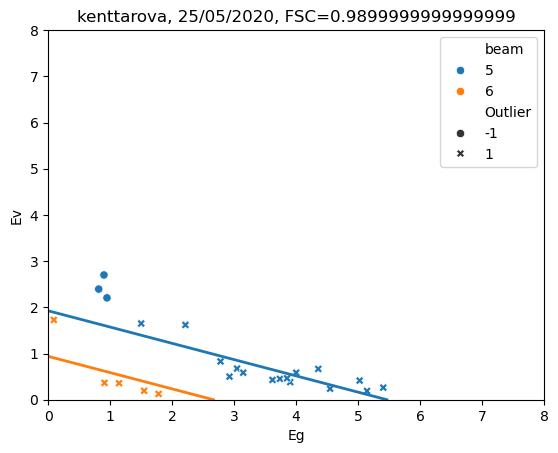

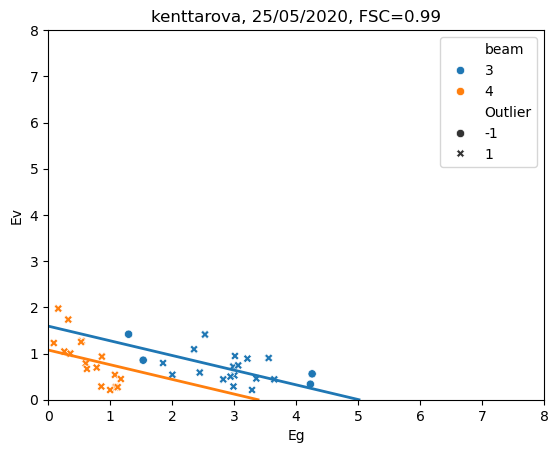

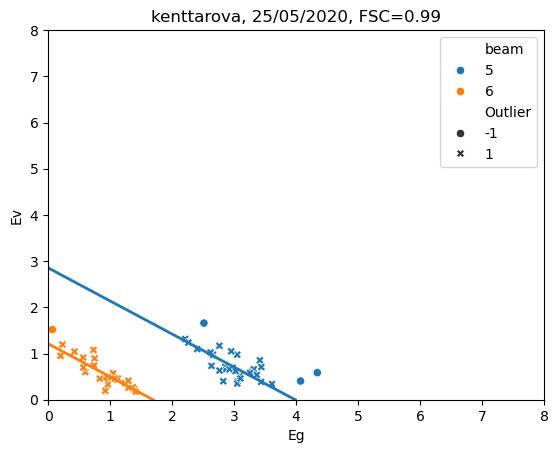

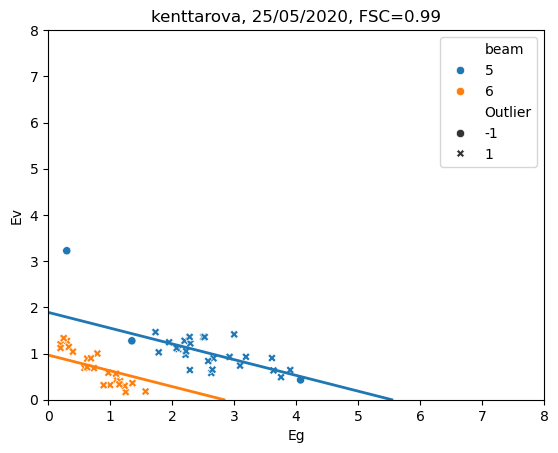

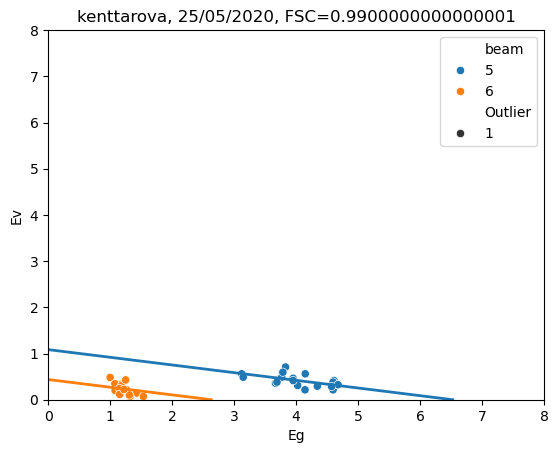

In [19]:
from scripts.parallel_blocks_WIP import *
    
# misclassified.columns
for idx, row in frac_data.sort_values('FSC').iterrows():
    plt.figure()
    plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
    
    test_plot = df[(df['camera'] == row['camera']) &
                   (df['date'] == row['date']) &
                   (df['lon'] == row['lon']) &
                   (df['lat'] == row['lat'])].copy()

    params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

    # print(test)

    # Get sorted unique beams (hue order used by seaborn)
    beam_order = sorted(test['beam'].unique())

    # Create mapping from beam label to tab10 color
    tab10 = cm.get_cmap('tab10')
    color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

    # Plot with fixed hue order and palette
    sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
                    hue_order=beam_order, palette=color_map)

    # Plot ODR lines in matching colors
    for b, beam in zip(params[1:], beam_order):
        plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.legend()
    plt.show()

    # break